In [3]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data 1_6.csv')

In [5]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 4s 81ms/step - loss: 0.0524 - val_loss: 0.0302
Epoch 2/100
19/19 [==============================] - 1s 53ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 3/100
19/19 [==============================] - 1s 74ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 4/100
19/19 [==============================] - 2s 87ms/step - loss: 6.8441e-04 - val_loss: 1.4670e-04
Epoch 5/100
19/19 [==============================] - 2s 91ms/step - loss: 4.8715e-04 - val_loss: 9.3210e-05
Epoch 6/100
19/19 [==============================] - 2s 87ms/step - loss: 4.6027e-04 - val_loss: 1.0059e-04
Epoch 7/100
19/19 [==============================] - 1s 54ms/step - loss: 4.4565e-04 - val_loss: 9.9337e-05
Epoch 8/100
19/19 [==============================] - 1s 53ms/step - loss: 4.3277e-04 - val_loss: 1.1569e-04
Epoch 9/100
19/19 [==============================] - 1s 53ms/step - loss: 4.0651e-04 - val_loss: 1.0115e-04
Epoch 10/100
19/19 [==============================] 

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

7/7 [==============================] - 0s 29ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16363.24202016299


In [16]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99951096681086
Testing MAE: 16240.33082048654


In [17]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.043772850185632706], [0.04080895334482193], [0.03737599402666092], [0.03368266671895981], [0.02980830892920494], [0.02579193003475666], [0.021658139303326607], [0.01742492988705635], [0.013106325641274452], [0.00871358159929514], [0.004255794454365969], [-0.000259642256423831], [-0.004826691001653671], [-0.0094404062256217], [-0.014096720144152641], [-0.018792279064655304], [-0.02352430857717991], [-0.028290510177612305], [-0.03308897837996483], [-0.03791812062263489], [-0.042776595801115036], [-0.04766330495476723], [-0.052577268332242966], [-0.057517677545547485], [-0.06248382851481438], [-0.06747512519359589], [-0.07249102741479874], [-0.07753098011016846], [-0.08259464055299759], [-0.08768149465322495], [-0.09279119223356247], [-0.09792333096265793], [-0.10307756066322327], [-0.10825346410274506], [-0.11345069855451584], [-0.11866890639066696], [-0.12390768527984619], [-0.12916666269302368], [-0.13444538414478302], [-0.13974349200725555], [-0.14506050944328308], [-0.15039606392

In [18]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[ 13844.45136584],
       [ 13601.06801286],
       [ 13319.16712549],
       [ 13015.88586029],
       [ 12697.73909603],
       [ 12367.93012673],
       [ 12028.47976703],
       [ 11680.86554261],
       [ 11326.23903636],
       [ 10965.52446661],
       [ 10599.46881741],
       [ 10228.67921647],
       [  9853.65144171],
       [  9474.79160238],
       [  9092.43372864],
       [  8706.85321233],
       [  8318.27787688],
       [  7926.89646626],
       [  7532.86545135],
       [  7136.31560695],
       [  6737.3570592 ],
       [  6336.08005033],
       [  5932.56503363],
       [  5526.87839067],
       [  5119.07793768],
       [  4709.2126196 ],
       [  4297.32679281],
       [  3883.46603727],
       [  3467.65849635],
       [  3049.94638506],
       [  2630.35845855],
       [  2208.92775467],
       [  1785.68302858],
       [  1360.65854174],
       [   933.8824375 ],
       [   505.38408282],
       [    75.19651556],
       [  -356.6496737 ],
       [  -7

In [19]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [20]:
print(y_pred_with_test_data.shape)
test_data.shape

(320,)


(320, 1)

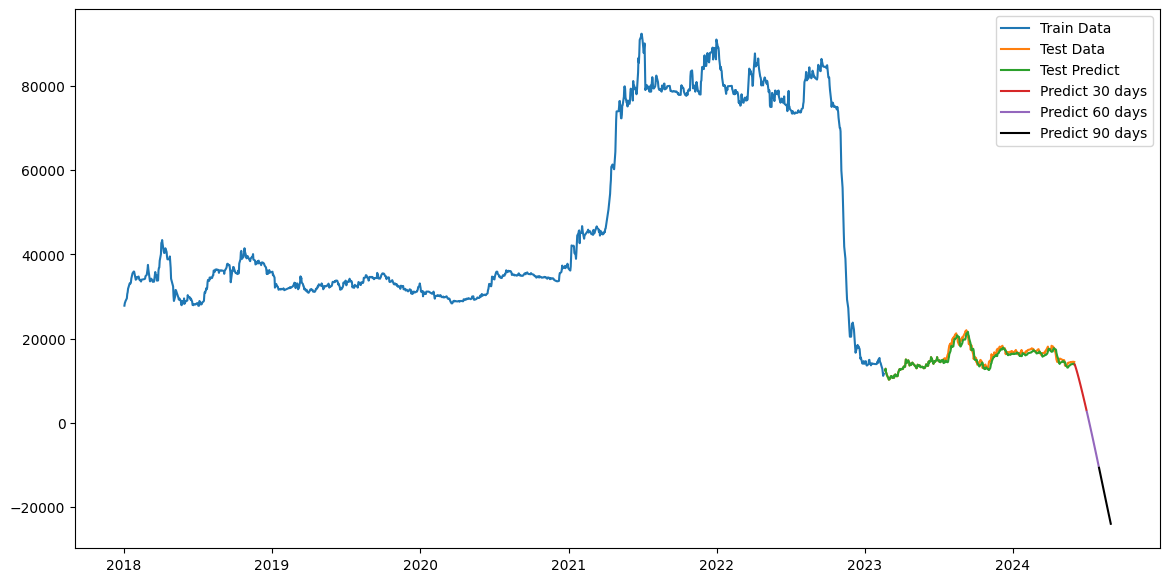

In [21]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()